In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import random

import torch
import torchvision.transforms as T

from dataloader import DatasetMNIST, tensor2img
from trainer import train_model

# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [2]:
# path setup
root = os.path.join(os.getcwd(), 'dirty_mnist')
train_path = os.path.join(root, 'train/')
dirty_mnist_answer = pd.read_csv(os.path.join(root, "dirty_mnist_2nd_answer.csv"))

In [3]:
# 사용할 샘플 데이터
image = Image.open(train_path + str(dirty_mnist_answer.iloc[100,0]).zfill(5) + '.png').convert('RGB')
label = dirty_mnist_answer.iloc[100, 1:].values.astype('float')

In [ ]:
### mix up

In [60]:
def mixup(image, label):
    idxs = np.random.randint(1, len(dirty_mnist_answer), 3)
    h, w = image.size
    
    images = [Image.open(train_path + str(dirty_mnist_answer.iloc[index,0]).zfill(5) + '.png').convert('RGB') for index in idxs]
    images.append(image)
    labels = [dirty_mnist_answer.iloc[index, 1:].values.astype('float') for index in idxs]
    labels.append(label)
    
    expand_img[:h, :w, :] = np.array(images[0])
    expand_img[:h, w:int(w*2), :] = np.array(images[1])
    expand_img[h:int(h*2), 0:w, :] = np.array(images[2])
    expand_img[h:int(h*2), w:int(w*2), :] = np.array(images[3])
    
    del images
    return Image.fromarray(expand_img).resize((h,w)), np.clip(np.sum(np.array(labels), axis=0), 0, 1)

['a', 'b', 'c', 'd', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


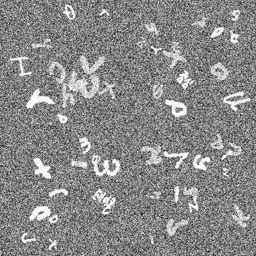

In [72]:
image = Image.open(train_path + str(dirty_mnist_answer.iloc[101,0]).zfill(5) + '.png').convert('RGB')
label = dirty_mnist_answer.iloc[101, 1:].values.astype('float')

image, label = mixup(image, label)

decoder_l = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
               'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
print([decoder_l[ii] for ii, k in enumerate(label) if k == 1.])
image

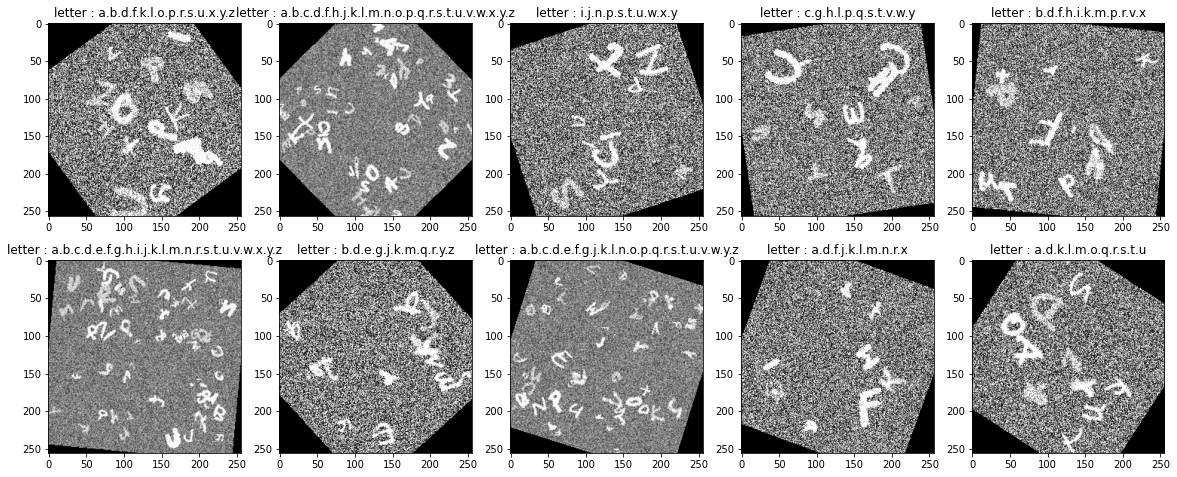

In [3]:
# mix up test
root = os.path.join(os.getcwd(), 'dirty_mnist')
train_path = os.path.join(root, 'train')
dirty_mnist_answer = pd.read_csv(os.path.join(root, "dirty_mnist_2nd_answer.csv"))

datasets = DatasetMNIST(train_path + '/', meta_df=dirty_mnist_answer, mode='train', mix_up=True)

decoder_l = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
               'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

# sample 이미지 보기
fig, ax = plt.subplots(2, 5, figsize=(5*4, 2*4))
for i, data in enumerate(datasets):
    if i == 10:
        break
    img, label = data['image'], data['label']
    row = i // 5
    col = i % 5
    ax[row, col].imshow(tensor2img(img))
    ax[row, col].set_title("letter : {}".format(".".join([decoder_l[ii] for ii, k in enumerate(label) if k == 1.])))
plt.show()

In [4]:
## reverse

In [19]:
def diagonal_reverse(img):
    transformed_img = img.copy()
    center = img.shape[0] // 2
    transformed_img[0:center, 0:center] = img[center:center + center, center:center + center]
    transformed_img[0:center, center:center + center]  = img[center:center*2, 0:center]
    transformed_img[center:center + center, 0:center] = img[0:center, center:center*2]
    transformed_img[center:center + center, center:center + center] = img[0:center, 0:center]
    
    return transformed_img

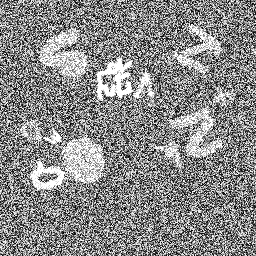

In [16]:
image

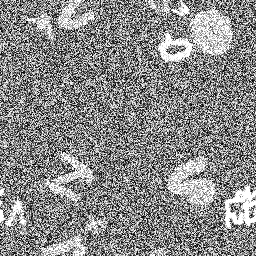

In [20]:
Image.fromarray(diagonal_reverse(np.array(image)))

In [21]:
# cut out
import torch
import numpy as np

class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [41]:
tranforms = T.Compose([ T.ToTensor(), 
                       Cutout(20, 20),])

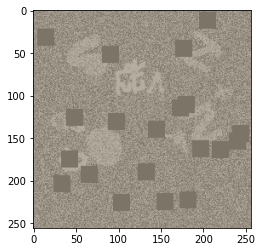

In [42]:
plt.imshow(tensor2img(tranforms(image)))